# Stock and Cryptocurrency Price Prediction using LSTM

Trading is a very complex endeavour. It requires a heavy knowledge of statistics, current market trends, market news and a little bit of luck. In this notebook we will be training a machine learning model to predict the future price of a stock ot a cryptocurrency based on the historical closing price data. 

To improve our chances for success we will be using an LSTM model. LSTM stands for Long Short Term Memory and is a type of recurrent neural network (RNN). RNNs are a type of neural network that can remember the previous state of the model and use it in the current state. This is very useful for time series data like stock prices.

Note that this model cannot be used to predict the price of a stock or cryptocurrency with 100% accuracy. It is just a tool to help you make better trading decisions based on historical data and should not be used as the sole basis for your trading strategy. As we all know markets are very volatile and can be affected by the things that happen in the real world and not always data.

## Notebook Initialization

In [1]:
import warnings
warnings.filterwarnings('ignore')

We will be setting the random seed for this notebook to a fixed number so that the results are reproduceable. This is helpful when you are debugging your code and want to make sure that the model is maximum optimized without having to deal with the randomness of the model.

In [2]:
import tensorflow as tf
import random
import os
import numpy as np
np.random.seed(0)


os.environ['PYTHONHASHSEED'] = '0'
random.seed(0)
tf.random.set_seed(0)

## Get the Data

The first step of course is to get the data we want to train our model on. I will be using the popular currency Bitcoin and its historical closing price data. The source for this data is Yahoo Finance and you can go check it out [here](https://finance.yahoo.com/quote/BTC-USD/history?p=BTC-USD). 

The yfinance library makes it very easy to get the data we want. We just need to pass in the ticker symbol of the stock or cryptocurrency we want to get the data for and the start and end date of the data we want. In this case I've asked the library to get all available data for Bitcoin from the beginning of its records.

In [3]:
import yfinance as yahooFinance
import pandas as pd

getBTCInfo = yahooFinance.Ticker("BTC-USD")
historical_data = getBTCInfo.history(period="max")

In [4]:
historical_data.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2014-09-17 00:00:00+00:00,465.864014,468.174011,452.421997,457.334015,21056800,0.0,0.0
2014-09-18 00:00:00+00:00,456.859985,456.859985,413.104004,424.440002,34483200,0.0,0.0
2014-09-19 00:00:00+00:00,424.102997,427.834991,384.532013,394.795990,37919700,0.0,0.0
2014-09-20 00:00:00+00:00,394.673004,423.295990,389.882996,408.903992,36863600,0.0,0.0
2014-09-21 00:00:00+00:00,408.084991,412.425995,393.181000,398.821014,26580100,0.0,0.0


## Data Visualization

Here we will be visualizing the closing price of Bitcoin over time. We will be using the matplotlib library to plot the data.

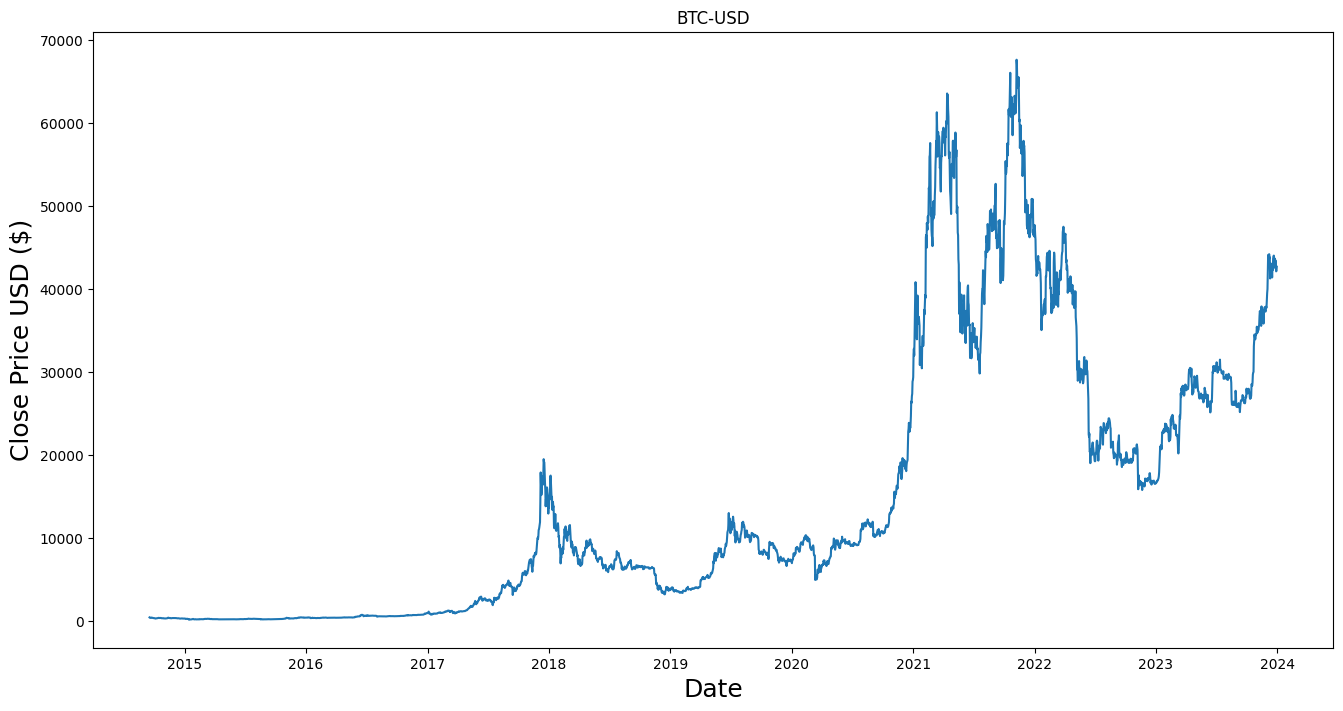

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16,8))
plt.title('BTC-USD')
plt.plot(historical_data.Close)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price USD ($)',fontsize=18)
plt.show()

## Data Preprocessing

As we can see above, the index column of the returned dataframe (i.e. the date and time) is in a format that need not mention the time as it is always constant. So to just make the column more readable we will be removing the time from the index column.

In [6]:
historical_data.index = pd.to_datetime(historical_data.index).date

We will also be removing all columns except the closing price column as we will only be using that column to train our model. The other columns are not needed. 

In [7]:
historical_data = historical_data.filter(['Close'])

The last row of the dataframe is removed as that is the current trading day and the closing price for it is not final yet so we cannot use it to train nor test our model.

In [8]:
historical_data = historical_data[:-1]

Next we convert the dataset into a numpy array as that is the format that the LSTM model expects. We also calculate how many rows will be used for training. In this case we will be using 80% of the data for training and 20% for testing.

In [9]:
dataset = historical_data.values
training_data_len = int(np.ceil( len(dataset) * .8 ))

We then scale the data in the range 0 to 1 using the MinMaxScaler function from the sklearn library. This is done to make the training process faster and more accurate.

In [10]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

## Model Building

Now we will build the training data. 
- We first separate the training dataset from the main dataset and store it in `train_data`. 
- Next we build the `x_train` and `y_train` arrays with the logic that every 60 values in the dataset will be able to predict the following value.
- Therefore `x_train` will be a 2 dimensional array wherin the inner arrays have 60 values which will predict the value of the corresponding value in `y_train`.

In [11]:
train_data = scaled_data[0:training_data_len , : ]

x_train, y_train = [], []

for i in range(60,len(train_data)):
    x_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i,0])

Just to demonstrate I will print the first occurences of `x_train` and `y_train`.

In [12]:
print("x_train")
display(x_train[0])
print("y_train")
display(y_train[0])

x_train


array([0.00414359, 0.00365546, 0.00321557, 0.00342492, 0.0032753 ,
       0.00332473, 0.0038239 , 0.00363714, 0.00346454, 0.00335845,
       0.00328567, 0.00295417, 0.00292874, 0.00309905, 0.00304965,
       0.00292288, 0.00269198, 0.00223721, 0.00211322, 0.00225521,
       0.00234585, 0.00259445, 0.0027738 , 0.0027224 , 0.00273334,
       0.00297447, 0.00315054, 0.0033057 , 0.00321523, 0.00303393,
       0.00305177, 0.0031658 , 0.00313766, 0.00303822, 0.00309209,
       0.00304287, 0.00267573, 0.00267466, 0.00251033, 0.00262063,
       0.00259518, 0.00266387, 0.00233701, 0.00248116, 0.00237752,
       0.00219096, 0.00219308, 0.00221774, 0.00226134, 0.00239481,
       0.00254029, 0.00243827, 0.00248387, 0.00274766, 0.00280197,
       0.00281341, 0.00364242, 0.00360048, 0.00326041, 0.00293862])

y_train


0.0031129686946921404

Now we convert `x_train` and `y_train` to numpy arrays. We will also make the `x_train` array 3 Dimensional because the LSTM model expects a 3D matrix as its input.

In [13]:
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

Now we start building our model using the Sequiential model from keras. We will be adding a few LSTM and Dense layers to the model which, after a bit of trial and error, showed the best results so far.

In [14]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

In [15]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(25))
model.add(Dense(1))

Now we compile the model using the `adam` compiler and `mean_squared_error` as its loss function. Then we fit the model to the training data we have prepared. The number of epochs is based off of trial and error and considerations have been taken to maximise the speed of training and minimise the loss as much as possible.

In [16]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size=1, epochs=4)


Epoch 1/4

2654/2654 [==============================] - 52s 18ms/step - loss: 0.0019
Epoch 2/4
2654/2654 [==============================] - 48s 18ms/step - loss: 0.0010
Epoch 3/4
2654/2654 [==============================] - 42s 16ms/step - loss: 7.2253e-04
Epoch 4/4
2654/2654 [==============================] - 42s 16ms/step - loss: 4.5906e-04


## Model Testing

Now we create the test data the same way the training data was created and we use the model to predict closing prices of Bitcoin and also find out the amount of error we get from the model.

We also do an extra step at the end to reverse the effects of the scaler and bring the values back to their original state.

In [17]:
test_data = scaled_data[training_data_len - 60:, :]

x_test = []
y_test = dataset[training_data_len:, :]

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

22/22 [==============================] - 1s 12ms/step


Once we have the predictions down, we use the Mean Absolute Error formula to calculate the average error in every row.

In [18]:
mean_abs_err = np.mean(np.abs(predictions - y_test))
print('Mean Absolute Error: ', mean_abs_err)

Mean Absolute Error:  611.9040923442109


But the best way to see the results of our model is to visualize it in a graph and compare the predicted value graph to the actual values.

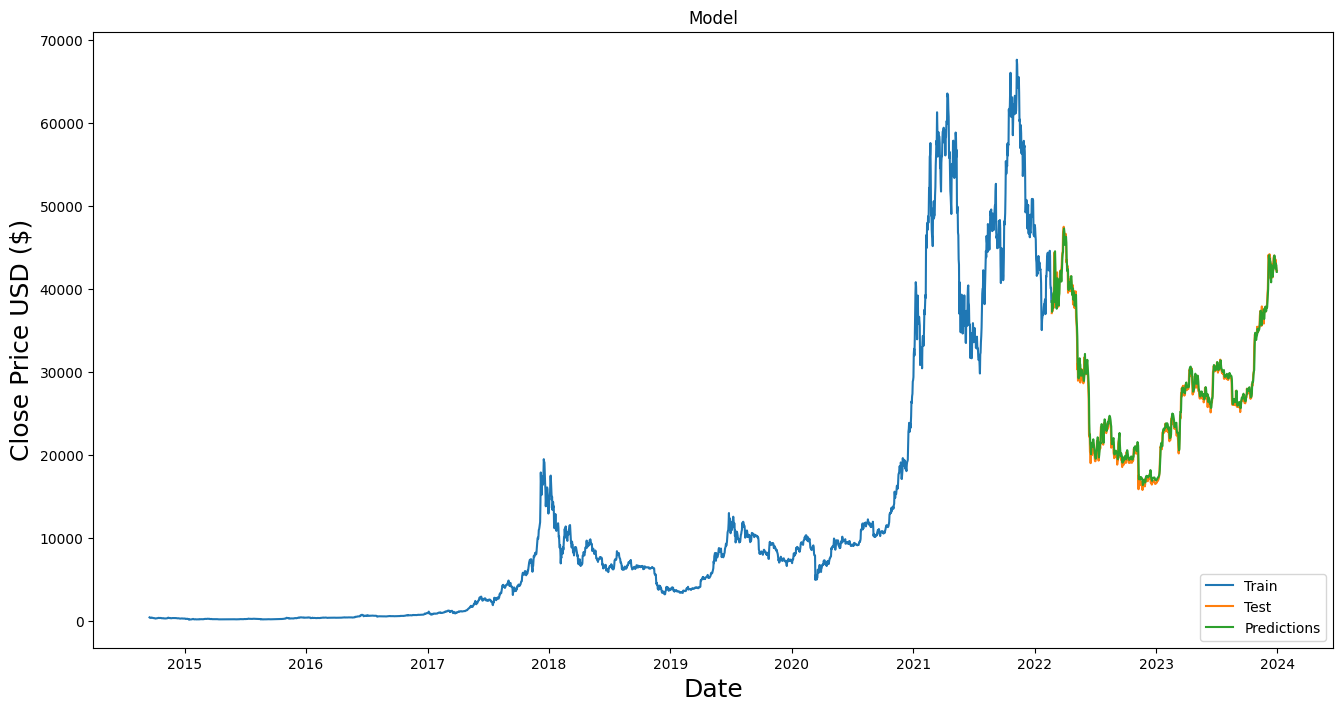

In [19]:
train = historical_data[:training_data_len]
valid = historical_data[training_data_len:]
valid['Predictions'] = predictions

plt.figure(figsize=(16, 8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Test', 'Predictions'], loc='lower right')
plt.show()

## Result

As we can see in this graph, the graph of predicted values `(in green)` is very similar to the data that was used to test the model `(in orange)` and this proves that our final model is effective enough to predict future stock or crypto data with respect to historical data.

As a conclusion I would like to stress that this model is not to be used as a sole trading strategy but as a tool to aid trading decisions for the user. Trading is a very volatile art that is influenced by a variety of external factors as well.